# Importing necessary libraries and dataset

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, recall_score, precision_recall_curve, roc_curve, precision_score, recall_score


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')
path =  '/content/drive/MyDrive/all_flights_preprocessed_with_and_without_leaks.csv'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(path,sep=";")

# EDA

In [ ]:
df.head()

,UTC_TIME,Flight,ID,VALUE_FOB,VALUE_FOB_EXPECTED,VALUE_FOB_DIFF,FUEL_USED_1,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,...,FUEL_LOADED_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,VALUE_FUEL_QTY_LXT,VALUE_FUEL_QTY_RXT,LEAK_FLOW,TARGET
0,2016-08-26 06:37:00,37_16.0,16.0_F-RBAJ,37228.333333,36800.890320,-427.443014,623.952576,621.907532,626.026062,618.223511,...,39291.0,4017.0,1889.0,2656.0,2685.0,1871.0,12225.0,11892.0,0.16,1
1,2016-08-26 06:37:01,37_16.0,16.0_F-RBAJ,37229.435418,36799.774841,-429.660577,624.230164,622.183716,626.308105,618.503174,...,39291.0,4013.0,1889.0,2656.0,2684.0,1870.0,12228.0,11895.0,0.16,1
2,2016-08-26 06:37:02,37_16.0,16.0_F-RBAJ,37230.730430,36798.591370,-432.139060,624.506348,622.460754,626.624023,618.817505,...,39291.0,4009.0,1889.0,2656.0,2684.0,1870.0,12230.0,11896.0,0.16,1
3,2016-08-26 06:37:03,37_16.0,16.0_F-RBAJ,37229.565736,36797.446716,-432.119020,624.782471,622.771118,626.904785,619.094910,...,39291.0,4004.0,1889.0,2656.0,2684.0,1869.0,12232.0,11899.0,0.16,1
4,2016-08-26 06:37:04,37_16.0,16.0_F-RBAJ,37228.364136,36796.311584,-432.052551,625.091919,623.043701,627.182129,619.370667,...,39291.0,3999.0,1888.0,2656.0,2684.0,1869.0,12233.0,11903.0,0.16,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2497915 entries, 0 to 2497914
Data columns (total 21 columns):
 #   Column              Dtype  
---  ------              -----  
 0   UTC_TIME            object 
 1   Flight              object 
 2   ID                  object 
 3   VALUE_FOB           float64
 4   VALUE_FOB_EXPECTED  float64
 5   VALUE_FOB_DIFF      float64
 6   FUEL_USED_1         float64
 7   FUEL_USED_2         float64
 8   FUEL_USED_3         float64
 9   FUEL_USED_4         float64
 10  TOTAL_FUEL_USED     float64
 11  FUEL_LOADED_FOB     float64
 12  VALUE_FUEL_QTY_CT   float64
 13  VALUE_FUEL_QTY_FT1  float64
 14  VALUE_FUEL_QTY_FT2  float64
 15  VALUE_FUEL_QTY_FT3  float64
 16  VALUE_FUEL_QTY_FT4  float64
 17  VALUE_FUEL_QTY_LXT  float64
 18  VALUE_FUEL_QTY_RXT  float64
 19  LEAK_FLOW           float64
 20  TARGET              int64  
dtypes: float64(17), int64(1), object(3)
memory usage: 400.2+ MB


In [ ]:
df.describe()

,VALUE_FOB,VALUE_FOB_EXPECTED,VALUE_FOB_DIFF,FUEL_USED_1,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,TOTAL_FUEL_USED,FUEL_LOADED_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,VALUE_FUEL_QTY_LXT,VALUE_FUEL_QTY_RXT,LEAK_FLOW,TARGET
count,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06,2.497915e+06
mean,2.237319e+04,2.403508e+04,1.661884e+03,2.629081e+03,2.568240e+03,2.595812e+03,2.606960e+03,1.040000e+04,3.443517e+04,5.492789e+02,1.844478e+03,2.521142e+03,2.520783e+03,1.847869e+03,7.613919e+03,7.592602e+03,4.862462e-01,4.821613e-01
std,9.436682e+03,7.475081e+03,5.236394e+03,1.775830e+03,1.748302e+03,1.747354e+03,1.766716e+03,7.022240e+03,6.773436e+03,1.700559e+03,1.271278e+02,1.632253e+02,1.652431e+02,1.289988e+02,3.229006e+03,3.236901e+03,1.164082e+00,4.996818e-01
min,0.000000e+00,-3.134553e+03,-1.242050e+04,3.623853e+01,0.000000e+00,3.742762e+01,3.321774e+01,1.563427e+02,1.136400e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.685080e+04,1.837732e+04,-5.040330e+02,1.200985e+03,1.166495e+03,1.188394e+03,1.184556e+03,4.752950e+03,2.951600e+04,0.000000e+00,1.790000e+03,2.479000e+03,2.480000e+03,1.791000e+03,5.076000e+03,5.049000e+03,0.000000e+00,0.000000e+00
50%,2.294066e+04,2.380758e+04,-3.083297e+02,2.237600e+03,2.186161e+03,2.213842e+03,2.218074e+03,8.857714e+03,3.432600e+04,0.000000e+00,1.862000e+03,2.551000e+03,2.552000e+03,1.863000e+03,7.799000e+03,7.693000e+03,0.000000e+00,0.000000e+00
75%,2.886600e+04,2.918148e+04,3.044895e+02,3.757488e+03,3.683715e+03,3.716688e+03,3.736862e+03,1.486120e+04,3.922900e+04,8.000000e+00,1.935000e+03,2.624000e+03,2.624000e+03,1.938000e+03,1.029000e+04,1.030400e+04,1.600000e-01,1.000000e+00
max,4.840300e+04,4.809726e+04,3.184371e+04,9.069362e+03,8.786004e+03,8.783728e+03,9.014975e+03,3.565407e+04,4.900200e+04,1.199100e+04,2.281000e+03,2.984000e+03,2.874000e+03,2.464000e+03,1.369200e+04,1.398100e+04,5.120000e+00,1.000000e+00


In [ ]:
target_distribution = df['TARGET'].value_counts(normalize=True) * 100
print(target_distribution)

TARGET
0    51.783868
1    48.216132
Name: proportion, dtype: float64


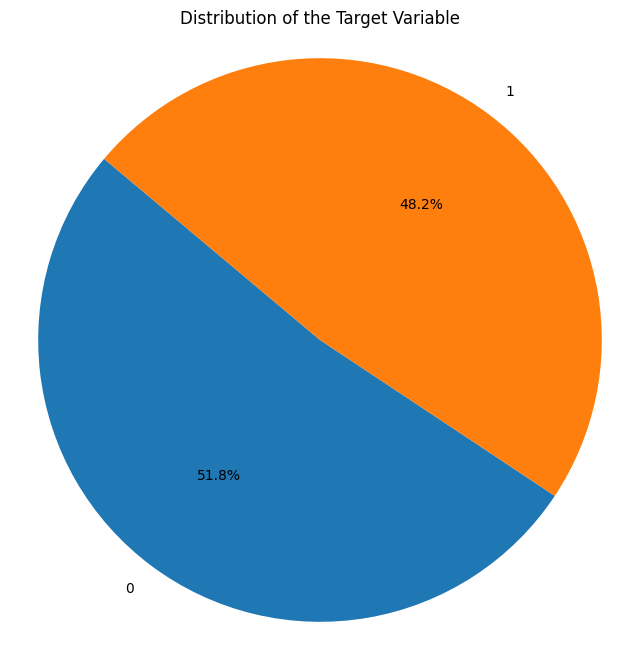

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(target_distribution, labels=target_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of the Target Variable')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Feature engineering

In [ ]:
# Check unique flights
unique_flights = df['Flight'].nunique()
print(f"Number of unique flights: {unique_flights}")

Number of unique flights: 523


We will create a new df keeping only the relevant features in order to reduce dimensionality and avoid introducing noise

In [ ]:
clean_df = df[['UTC_TIME','Flight', 'ID','VALUE_FOB','VALUE_FOB_EXPECTED','VALUE_FOB_DIFF','TOTAL_FUEL_USED','TARGET']]

In [ ]:
clean_df.head()

,UTC_TIME,Flight,ID,VALUE_FOB,VALUE_FOB_EXPECTED,VALUE_FOB_DIFF,TOTAL_FUEL_USED,TARGET
0,2016-08-26 06:37:00,37_16.0,16.0_F-RBAJ,37228.333333,36800.890320,-427.443014,2490.109680,1
1,2016-08-26 06:37:01,37_16.0,16.0_F-RBAJ,37229.435418,36799.774841,-429.660577,2491.225159,1
2,2016-08-26 06:37:02,37_16.0,16.0_F-RBAJ,37230.730430,36798.591370,-432.139060,2492.408630,1
3,2016-08-26 06:37:03,37_16.0,16.0_F-RBAJ,37229.565736,36797.446716,-432.119020,2493.553284,1
4,2016-08-26 06:37:04,37_16.0,16.0_F-RBAJ,37228.364136,36796.311584,-432.052551,2494.688416,1


## Create rolling features for time series data

In [ ]:
import pandas as pd
import numpy as np # Import numpy for np.number


# Define a function to extract rolling features, as they are useful for time series data
def extract_rolling_features(df, window_size=60):
    # Initialize an empty list to store features
    feature_dfs = []  # Use a list to store dataframes

    # List of numerical features
    numerical_features = clean_df.select_dtypes(include=[np.number]).columns.tolist()

    # Ensure you're removing the correct column name
    if 'Flight' in numerical_features:
        numerical_features.remove(['Flight','TARGET'])

    # Extract features for each flight
    flight_ids = clean_df['Flight'].unique()

    for flight_id in flight_ids:
        flight_data = clean_df[clean_df['Flight'] == flight_id].copy()

        for feature in numerical_features:
            flight_data[f'rolling_mean_{feature}'] = flight_data[feature].rolling(window=window_size).mean().fillna(0)
            flight_data[f'rolling_std_{feature}'] = flight_data[feature].rolling(window=window_size).std().fillna(0)

        # Append the features to the feature dataframe list
        feature_dfs.append(flight_data)  # Append to the list

    # Concatenate all dataframes into one
    feature_df = pd.concat(feature_dfs, ignore_index=True)

    return feature_df

# Apply the function to extract rolling features
window_size = 60  # Set your desired window size
rolling_features_df = extract_rolling_features(clean_df, window_size=window_size)

# Display the first few rows of the resulting dataframe
print(rolling_features_df.tail())

                    UTC_TIME    Flight            ID  VALUE_FOB  \
2497910  2018-04-22 11:45:41  53_429.0  429.0_F-RBAK    18236.0   
2497911  2018-04-22 11:45:42  53_429.0  429.0_F-RBAK    18235.0   
2497912  2018-04-22 11:45:43  53_429.0  429.0_F-RBAK    18234.0   
2497913  2018-04-22 11:45:44  53_429.0  429.0_F-RBAK    18234.0   
2497914  2018-04-22 11:45:45  53_429.0  429.0_F-RBAK    18231.0   

         VALUE_FOB_EXPECTED  VALUE_FOB_DIFF  TOTAL_FUEL_USED  TARGET  \
2497910        17869.464844     -366.535156     14009.535156       0   
2497911        17868.274170     -366.725830     14010.725830       0   
2497912        17867.045898     -366.954102     14011.954102       0   
2497913        17865.853760     -368.146240     14013.146240       0   
2497914        17865.709229     -365.290771     14013.290771       0   

         rolling_mean_VALUE_FOB  rolling_std_VALUE_FOB  \
2497910            18283.233333              28.196866   
2497911            18281.716667              28.

**Adding rolling statistics**

In [ ]:
rolling_features_df.head()

,UTC_TIME,Flight,ID,VALUE_FOB,VALUE_FOB_EXPECTED,VALUE_FOB_DIFF,TOTAL_FUEL_USED,TARGET,rolling_mean_VALUE_FOB,rolling_std_VALUE_FOB,rolling_mean_VALUE_FOB_EXPECTED,rolling_std_VALUE_FOB_EXPECTED,rolling_mean_VALUE_FOB_DIFF,rolling_std_VALUE_FOB_DIFF,rolling_mean_TOTAL_FUEL_USED,rolling_std_TOTAL_FUEL_USED,rolling_mean_TARGET,rolling_std_TARGET
0,2016-08-26 06:37:00,37_16.0,16.0_F-RBAJ,37228.333333,36800.890320,-427.443014,2490.109680,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-08-26 06:37:01,37_16.0,16.0_F-RBAJ,37229.435418,36799.774841,-429.660577,2491.225159,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-08-26 06:37:02,37_16.0,16.0_F-RBAJ,37230.730430,36798.591370,-432.139060,2492.408630,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-08-26 06:37:03,37_16.0,16.0_F-RBAJ,37229.565736,36797.446716,-432.119020,2493.553284,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-08-26 06:37:04,37_16.0,16.0_F-RBAJ,37228.364136,36796.311584,-432.052551,2494.688416,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# XGBoost

We are picking a 80/20 split on the flights, we want to pick entire flights

In [ ]:
flight_indices = rolling_features_df['Flight'].unique()

# Train-Test Split on flight indices
train_indices, test_indices = train_test_split(flight_indices, test_size=0.2, random_state=42) #stratify='TARGET'

# Create train and test datasets based on the split flight indices
train_data = rolling_features_df[rolling_features_df['Flight'].isin(train_indices)]
test_data = rolling_features_df[rolling_features_df['Flight'].isin(test_indices)]

# Split the data into features and target variable
X_train = train_data.drop(['Flight', 'ID', 'TARGET','UTC_TIME','rolling_std_TARGET','rolling_mean_TARGET'], axis=1)
y_train = train_data['TARGET']
X_test = test_data.drop(['Flight', 'ID','TARGET','UTC_TIME','rolling_std_TARGET', 'rolling_mean_TARGET'], axis=1)
y_test = test_data['TARGET']

In [ ]:
X_train.head()

,VALUE_FOB,VALUE_FOB_EXPECTED,VALUE_FOB_DIFF,TOTAL_FUEL_USED,rolling_mean_VALUE_FOB,rolling_std_VALUE_FOB,rolling_mean_VALUE_FOB_EXPECTED,rolling_std_VALUE_FOB_EXPECTED,rolling_mean_VALUE_FOB_DIFF,rolling_std_VALUE_FOB_DIFF,rolling_mean_TOTAL_FUEL_USED,rolling_std_TOTAL_FUEL_USED
4738,33635.000000,33216.680603,-418.319397,2341.319397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4885,27740.000000,27243.326492,-496.673508,597.673508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4886,27736.649061,27242.848190,-493.800870,598.151810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4887,27733.346437,27242.398727,-490.947710,598.601273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4888,27729.967333,27241.934540,-488.032793,599.065460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Perform Randomized Grid Search to find best hyperparemeters

In [ ]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', device = "cuda")

# Define the hyperparameter grid
param_dist = {
    'n_estimators': np.arange(50, 200, 50),
    'max_depth': np.arange(3, 10, 2),
    'learning_rate': np.logspace(-2, 0, 5),
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': np.logspace(-2, 0, 3),
    'reg_alpha': np.logspace(-2, 0, 3),
    'reg_lambda': np.logspace(-2, 0, 3)
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_dist,
                                   n_iter=40, scoring='roc_auc',
                                   cv=3, verbose=2, n_jobs=1, random_state=42)
random_search.fit(X_train, y_train)

print(f"Best parameters found: {random_search.best_params_}")

# Evaluate the best model
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC on test set: {roc_auc}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1.0, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1.0, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=150, reg_alpha=0.01, reg_lambda=1.0, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.1, max_depth=7, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1, subsample=0.9; total time=   3.9s
[CV] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.1, max_depth=7, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1, subsample=0.9; total time=   4.8s
[CV] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.1, max_depth=7, n_estimators=100, reg_alpha=1.0, reg_lambda=0.1, subsample=0.9; total tim

### Train again with the best parameters

In [ ]:
best_params = {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.01, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
xgb_clf = xgb.XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

In [ ]:
best_model = xgb_clf
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC on test set: {roc_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.78      0.72    184496
           1       0.81      0.70      0.75    242727

    accuracy                           0.73    427223
   macro avg       0.73      0.74      0.73    427223
weighted avg       0.74      0.73      0.73    427223

ROC AUC on test set: 0.8182439470226444


## Evaluating the Model

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Seleccionar el umbral que maximiza el recall
optimal_idx = np.argmax(recall)
optimal_threshold = thresholds[optimal_idx]

# Hacer predicciones con el umbral óptimo
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Calcular el recall con el umbral óptimo
optimal_recall = recall_score(y_test, y_pred_optimal)
print(f"Optimal threshold: {optimal_threshold}")
print(f"Recall with optimal threshold: {optimal_recall}")

Optimal threshold: 0.0011055850191041827
Recall with optimal threshold: 1.0


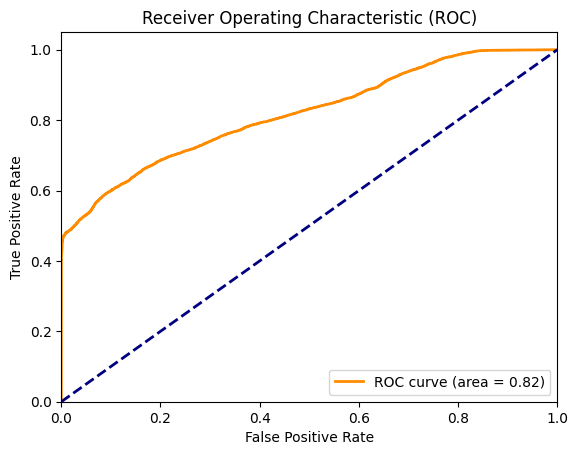

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Feature Importance

In [ ]:
X_train.columns

Index(['VALUE_FOB', 'VALUE_FOB_EXPECTED', 'VALUE_FOB_DIFF', 'TOTAL_FUEL_USED',
       'rolling_mean_VALUE_FOB', 'rolling_std_VALUE_FOB',
       'rolling_mean_VALUE_FOB_EXPECTED', 'rolling_std_VALUE_FOB_EXPECTED',
       'rolling_mean_VALUE_FOB_DIFF', 'rolling_std_VALUE_FOB_DIFF',
       'rolling_mean_TOTAL_FUEL_USED', 'rolling_std_TOTAL_FUEL_USED'],
      dtype='object')

In [ ]:
feature_columns = ['VALUE_FOB', 'VALUE_FOB_EXPECTED', 'VALUE_FOB_DIFF', 'TOTAL_FUEL_USED',
       'rolling_mean_VALUE_FOB', 'rolling_std_VALUE_FOB',
       'rolling_mean_VALUE_FOB_EXPECTED', 'rolling_std_VALUE_FOB_EXPECTED',
       'rolling_mean_VALUE_FOB_DIFF', 'rolling_std_VALUE_FOB_DIFF',
       'rolling_mean_TOTAL_FUEL_USED', 'rolling_std_TOTAL_FUEL_USED']
target_column = 'TARGET'

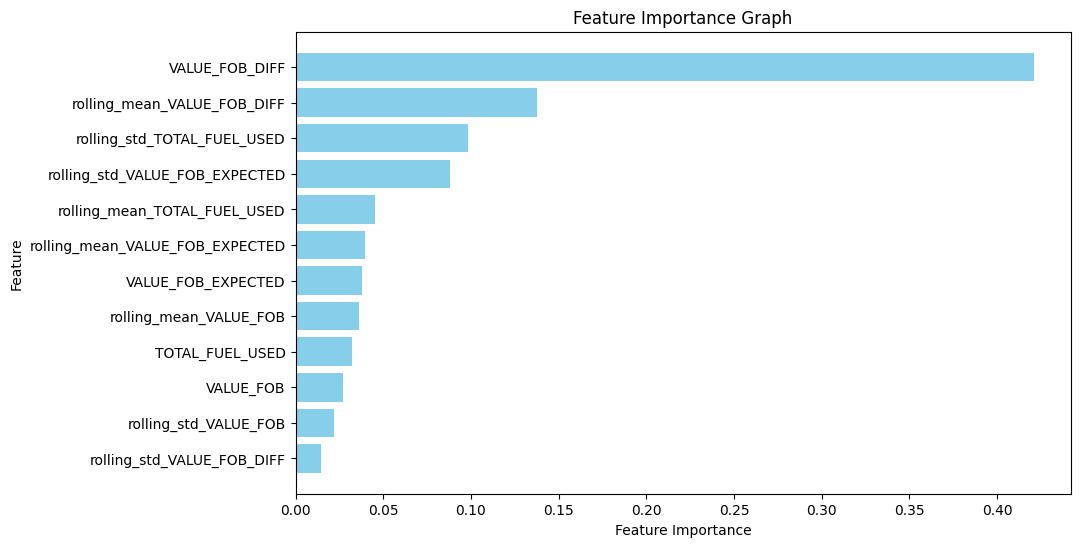

In [ ]:
feature_importances = best_model.feature_importances_

# Create a DataFrame for the feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Graph')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

## Predicting over a all flights

In [ ]:
features = rolling_features_df.drop(columns=['Flight', 'ID', 'TARGET', 'UTC_TIME', 'rolling_std_TARGET', 'rolling_mean_TARGET'])

predictions = best_model.predict(features)

# Create a DataFrame for the predictions
predictions_df = rolling_features_df[['Flight', 'TARGET']].copy()
predictions_df['Prediction'] = predictions

# Group by 'Flight' and calculate the average prediction
grouped_df = predictions_df.groupby('Flight').agg(
    average_prediction=('Prediction', 'mean'),
    target=('TARGET', 'first')).reset_index()

# Include the LEAK_FLOW column from df
leak_flow_df = df[['Flight', 'LEAK_FLOW']].drop_duplicates(subset=['Flight'])
grouped_df = grouped_df.merge(leak_flow_df, on='Flight', how='left')
#grouped_df = grouped_df.merge(df[['Flight', 'LEAK_FLOW']], on='Flight', how='left')

grouped_df['leak'] = (grouped_df['average_prediction'] > 0.4).astype(int)

print(grouped_df)

       Flight  average_prediction  target  LEAK_FLOW  leak
0    02_V0837            0.002674       1       0.16     0
1    02_V0884            0.135338       1       0.64     0
2    02_V0889            0.000000       1       0.01     0
3    02_V0926            0.000000       1       0.16     0
4    02_V0927            0.978182       1       5.12     1
..        ...                 ...     ...        ...   ...
518   53_92.0            0.000000       0       0.00     0
519   53_94.0            0.026667       0       0.00     0
520   53_95.0            0.372263       1       0.01     0
521   53_96.0            0.005654       0       0.00     0
522   53_97.0            1.000000       0       0.00     1

[523 rows x 5 columns]


In [ ]:
ftarget = grouped_df['target']
fleak = grouped_df['leak']

accuracy = accuracy_score(ftarget, fleak)
precision = precision_score(ftarget, fleak)
recall = recall_score(ftarget, fleak)

In [ ]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.7782026768642447
Precision: 0.8193832599118943
Recall: 0.7126436781609196


In [ ]:
grouped_df['correctly_cataloged'] = (grouped_df['leak'] == grouped_df['target']).astype(int)
grouped_df['incorrectly_cataloged'] = (grouped_df['leak'] != grouped_df['target']).astype(int)

# Group by LEAK_FLOW and calculate the number of correctly cataloged flights
result_df = grouped_df.groupby('LEAK_FLOW').agg(
    total_flights=('Flight', 'count'),
    correctly_cataloged_flights=('correctly_cataloged', 'sum')
).reset_index()

result_df['false_positives'] = grouped_df.groupby('LEAK_FLOW').apply(lambda x: ((x['leak'] == 1) & (x['target'] == 0)).sum()).values
result_df['false_negatives'] = grouped_df.groupby('LEAK_FLOW').apply(lambda x: ((x['leak'] == 0) & (x['target'] == 1)).sum()).values

# Calculate the accuracy
result_df['accuracy'] = result_df['correctly_cataloged_flights'] / result_df['total_flights']
result_df['recall'] = result_df['correctly_cataloged_flights'] / (result_df['correctly_cataloged_flights'] + result_df['total_flights'] - result_df['correctly_cataloged_flights'])
result_df['precision'] = result_df['correctly_cataloged_flights'] / result_df['total_flights']

# Print the final result
print("Cataloging Accuracy by LEAK_FLOW:")
print(result_df)

Cataloging Accuracy by LEAK_FLOW:
    LEAK_FLOW  total_flights  correctly_cataloged_flights  false_positives  \
0        0.00            262                          221               41   
1        0.01             27                           15                0   
2        0.02             26                           15                0   
3        0.04             26                           16                0   
4        0.08             26                           16                0   
5        0.16             26                           19                0   
6        0.32             26                           17                0   
7        0.64             26                           20                0   
8        1.28             26                           21                0   
9        2.56             26                           23                0   
10       5.12             26                           24                0   

    false_negatives  accuracy

## Sensitivity over different types of leaks

In [ ]:
grouped_df['correctly_cataloged'] = (grouped_df['leak'] == grouped_df['target']).astype(int)
grouped_df['incorrectly_cataloged'] = (grouped_df['leak'] != grouped_df['target']).astype(int)

# Group by LEAK_FLOW and calculate the number of correctly cataloged flights
result_df = grouped_df.groupby('LEAK_FLOW').agg(
    total_flights=('Flight', 'count'),
    correctly_cataloged_flights=('correctly_cataloged', 'sum')
).reset_index()

# Calculate false positives and false negatives
false_positives = grouped_df[grouped_df['leak'] == 1].groupby('LEAK_FLOW')['target'].apply(lambda x: (x == 0).sum())
false_negatives = grouped_df[grouped_df['leak'] == 0].groupby('LEAK_FLOW')['target'].apply(lambda x: (x == 1).sum())

result_df = result_df.merge(false_positives.rename('false_positives'), on='LEAK_FLOW', how='left')
result_df = result_df.merge(false_negatives.rename('false_negatives'), on='LEAK_FLOW', how='left')

# Calculate the accuracy, precision, and recall
result_df['accuracy'] = result_df['correctly_cataloged_flights'] / result_df['total_flights']
result_df['precision'] = result_df['correctly_cataloged_flights'] / (result_df['correctly_cataloged_flights'] + result_df['false_positives'])
result_df['recall'] = result_df['correctly_cataloged_flights'] / (result_df['correctly_cataloged_flights'] + result_df['false_negatives'])

# Fill NaN values with 0 (in case there are any divisions by zero)
result_df.fillna(0, inplace=True)

# Print the final result
print("Cataloging Accuracy by LEAK_FLOW:")
print(result_df)

Cataloging Accuracy by LEAK_FLOW:
    LEAK_FLOW  total_flights  correctly_cataloged_flights  false_positives  \
0        0.00            262                          221               41   
1        0.01             27                           15                0   
2        0.02             26                           15                0   
3        0.04             26                           16                0   
4        0.08             26                           16                0   
5        0.16             26                           19                0   
6        0.32             26                           17                0   
7        0.64             26                           20                0   
8        1.28             26                           21                0   
9        2.56             26                           23                0   
10       5.12             26                           24                0   

    false_negatives  accuracy

In [ ]:
result_df.head(11)

,LEAK_FLOW,total_flights,correctly_cataloged_flights,false_positives,false_negatives,accuracy,precision,recall
0,0.00,262,221,41,0,0.843511,0.843511,1.000000
1,0.01,27,15,0,12,0.555556,1.000000,0.555556
2,0.02,26,15,0,11,0.576923,1.000000,0.576923
3,0.04,26,16,0,10,0.615385,1.000000,0.615385
4,0.08,26,16,0,10,0.615385,1.000000,0.615385
5,0.16,26,19,0,7,0.730769,1.000000,0.730769
6,0.32,26,17,0,9,0.653846,1.000000,0.653846
7,0.64,26,20,0,6,0.769231,1.000000,0.769231
8,1.28,26,21,0,5,0.807692,1.000000,0.807692
9,2.56,26,23,0,3,0.884615,1.000000,0.884615


In [ ]:
confusion_matrix(ftarget, fleak)

array([[221,  41],
       [ 75, 186]])